In [1]:
%cd ..

/home/nftd/Documents/customer-lifetime-value


In [2]:
import random
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import data

In [4]:
df = pd.read_csv(
    filepath_or_buffer='data/trans.csv',
    usecols=['account_id', 'date'], 
    parse_dates=['date'],
    sep=';')

In [5]:
# define the training (calibration) and prediction (holdout) period

training_start = '1993-01-01'
training_end   = '1995-12-31'
holdout_start  = '1996-01-01'
holdout_end    = '1998-12-31'
date_format    = '%Y-%m-%d'

In [6]:
# display basic stats

cohort_accounts = df.groupby('account_id').min().query(
    'date <= @training_end').reset_index()['account_id'].tolist()

df = df.query('account_id in @cohort_accounts')
df = df.sort_values(by='account_id').reset_index(drop=True)

print(f"Accounts in dataset:  {len(df['account_id'].unique())}")
print(f"Total transactions: {len(df)}")

Accounts in dataset:  2239
Total transactions: 744015


## display basic plots

In [7]:
# count aggregate stats

aggregate_counts = df.copy(deep=True)
aggregate_counts['year'] = aggregate_counts['date'].dt.year
aggregate_counts['week'] = (aggregate_counts['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts = aggregate_counts.groupby(['year', 'week']).agg({'account_id': 'count', 'date': 'min'}).reset_index()

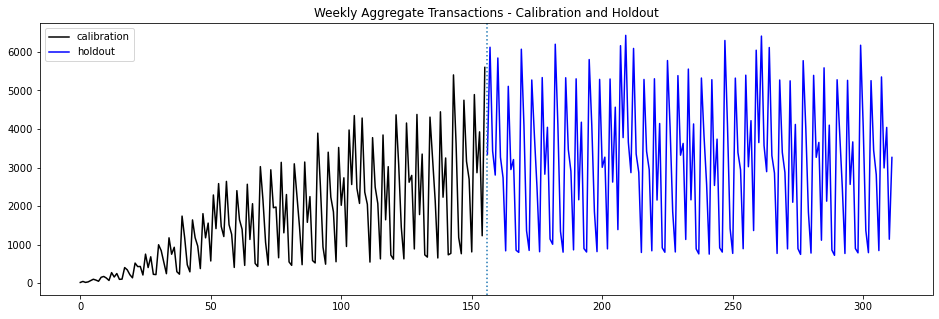

In [8]:
# display aggregate calibration and holdout transactions plot

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end].index, 
         aggregate_counts[aggregate_counts.date <= training_end]['account_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start]['account_id'], color='blue', label='holdout')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end]), linestyle=':')
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("calibration_holdout.png", dpi=600)
plt.show()

# note the prominent monthly pattern with spiky first weeks

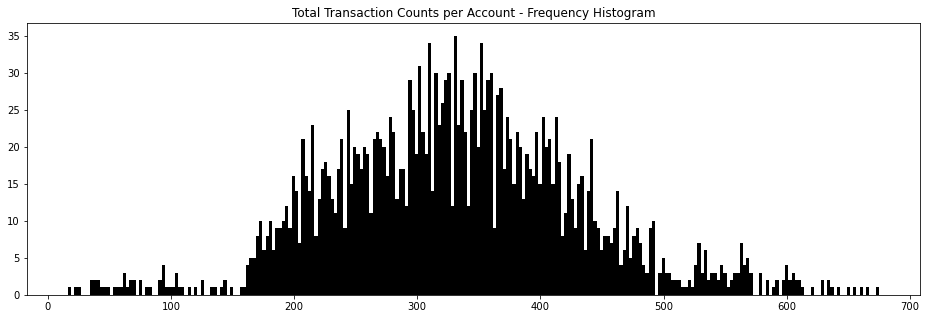

In [9]:
# display the distribution of total transaction counts per customer

transactions_per_account = list(df.groupby('account_id').count()['date'])

plt.figure(figsize=(16,5))
plt.hist(transactions_per_account, bins=250, color='black')
plt.title('Total Transaction Counts per Account - Frequency Histogram')
plt.savefig("transactions_histogram.png", dpi=600)
plt.show()

## training data preparation

In [10]:
# generate a list of dates between two dates
def date_range(start, end):
    start = datetime.datetime.strptime(start, date_format)
    end = datetime.datetime.strptime(end, date_format)
    r = (end+datetime.timedelta(days=1)-start).days
    return [start+datetime.timedelta(days=i) for i in range(r)]

# prepare a template for training samples to be filled with each customer's data
ed = pd.DataFrame(date_range(training_start, holdout_end), columns={'date'})
ed['year'] = ed['date'].dt.year      # 0-indexing 
ed['week'] = (ed['date'].dt.dayofyear // 7).clip(upper=51)

# save the holdout calendar for later use
holdout_calendar = ed[ed['date'] >= holdout_start].drop(columns=['date']).drop_duplicates().drop(columns=['year'])

# samples are training inputs
# targets are training labels
# calibration is stored for later use in prediction
# holdout is data not used in training
samples, targets, calibration, holdout = [], [], [], []
trans = 0 # total transaction count across all individuals

max_trans_per_week = 0
max_trans_cust = []

# shuffle data randomly
ids = df['account_id'].unique()
random.shuffle(ids)

# build a record for each customer
for account in tqdm(ids, desc='preparing dataset'):
    # take the data of single user, 
    subset = df.query('account_id == @account').groupby(
        ['date']).count().reset_index()
    user = subset.copy(deep=True)
    user = user.rename(columns={'account_id': 'transactions'})
    # copy the empty frame
    frame = ed.copy(deep=True)
    # insert customer ID
    frame['account_id'] = account
    # merge customer data into the empty frame
    frame = frame.merge(user, on=['date'], how='left')
    # aggregate weekly transactions
    frame = frame.groupby(['year', 'week']).agg(
        {'transactions': 'sum', 
         'date': 'min'}).sort_values(['date']).reset_index()
    # there is a small number of ids with 7 and more transactions per week
    # to make the job easier for the model, we can clip the value at 6:
    # frame['transactions'] = frame['transactions'].clip(upper=6)
    # this will however make the assertion following this block fail
    max_trans = max(frame['transactions'])
    max_trans_per_week = max(max_trans_per_week, max_trans)
    max_trans_cust.append(max_trans)
    # keep a count of the total transactions
    trans += user['transactions'].sum()
    # training sequences of everything until the holdout period
    training = frame[frame['date'] < holdout_start]
    training = training.drop(columns=['date', 'year']).astype(int)
    # store for later use
    calibration.append(training)
    # training sample: calibration sequence sans the final element
    sample = training[:-1].values
    samples.append(sample)
    # target labels: sequence of transaction counts starting 
    # with the 2nd element. At each step of the training
    # we use a row from the train_samples element as our input, 
    # and predict the corresponding element from train_targets
    target = training.loc[1:, 'transactions'].values
    targets.append(target)
    # keep holdout sequence to compare with predictions
    hold = frame[frame['date'] >= holdout_start]
    hold = hold.drop(columns='date')
    holdout.append(hold)
       
# check that we didn't lose any transactions along the way
assert trans == len(df)

print(f"Maximum transactions per account_id per time-unit found: {int(max_trans_per_week)}")

# create a validation set which won't be used in training
# we've already shuffled the data so we just grab the tail end
# of the list for validation, the rest is the training set
VALIDATION_SPLIT = 0.1
validation_size = round(len(samples) * VALIDATION_SPLIT)
valid_samples, valid_targets = samples[-validation_size:], targets[-validation_size:]
train_samples, train_targets = samples[:-validation_size], targets[:-validation_size]

preparing dataset: 100%|██████████| 2239/2239 [00:37<00:00, 59.27it/s]

Maximum transactions per account_id per time-unit found: 11


In [11]:
# number of samples in each dataset
no_train_samples, no_valid_samples = len(train_samples), len(valid_samples)

# batch size is the number of samples used to calculate
# the loss gradient at each step during the training
BATCH_SIZE_TRAIN = 32   

# for prediction this doesn't matter appart from memory constraint, 
# if you run out of memory you might need to set this to a smaller value 
BATCH_SIZE_PRED = no_valid_samples  
# validation loss also calculated in one step
BATCH_SIZE_VALID = no_valid_samples

# lenght of each training sequence:
seq_len = samples[0].shape[0]

## Build torch dataset

In [12]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, sample, target):
        'Initialization'
        self.sample = sample
        self.target = target

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.sample)

  def __getitem__(self, index):
        'Generates one sample of data'

        week = self.sample[index][:, 0]
        transaction = self.sample[index][:, 1]
        y = self.target[index]

        return (week, transaction), y

In [13]:
df_train = Dataset(
    sample=torch.tensor(train_samples), 
    target=torch.tensor(train_targets))
df_val= Dataset(
    sample=torch.tensor(valid_samples), 
    target=torch.tensor(valid_targets))

<ipython-input-13-8aab702001ec>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)
  sample=torch.tensor(train_samples),


In [14]:
train_samples[1][-20:]

array([[31,  1],
       [32,  0],
       [33,  0],
       [34,  0],
       [35,  1],
       [36,  0],
       [37,  0],
       [38,  0],
       [39,  0],
       [40,  1],
       [41,  0],
       [42,  0],
       [43,  0],
       [44,  1],
       [45,  0],
       [46,  0],
       [47,  0],
       [48,  1],
       [49,  1],
       [50,  0]])

In [15]:
train_targets[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       2])

In [16]:
torch.tensor(train_samples[0]).shape

torch.Size([155, 2])

In [17]:
torch.tensor(train_targets[0]).shape

torch.Size([155])

In [18]:
sampler = RandomSampler(df_train, replacement=True)

In [19]:
train_dataset = DataLoader(
    df_train,
    batch_size=BATCH_SIZE_TRAIN,
    sampler=sampler)
valid_dataset = DataLoader(
    df_val,
    batch_size=BATCH_SIZE_VALID,
    shuffle=False
)

In [20]:
check = next(iter(train_dataset))
check

[[tensor([[ 0,  1,  2,  ..., 48, 49, 50],
          [ 0,  1,  2,  ..., 48, 49, 50],
          [ 0,  1,  2,  ..., 48, 49, 50],
          ...,
          [ 0,  1,  2,  ..., 48, 49, 50],
          [ 0,  1,  2,  ..., 48, 49, 50],
          [ 0,  1,  2,  ..., 48, 49, 50]]),
  tensor([[0, 0, 0,  ..., 0, 2, 1],
          [0, 0, 0,  ..., 1, 1, 2],
          [0, 0, 0,  ..., 1, 4, 0],
          ...,
          [1, 1, 0,  ..., 1, 0, 1],
          [0, 0, 0,  ..., 1, 2, 0],
          [0, 0, 0,  ..., 0, 3, 1]])],
 tensor([[0, 0, 0,  ..., 2, 1, 2],
         [0, 0, 0,  ..., 1, 2, 2],
         [0, 0, 0,  ..., 4, 0, 2],
         ...,
         [1, 0, 0,  ..., 0, 1, 3],
         [0, 0, 0,  ..., 2, 0, 3],
         [0, 0, 0,  ..., 3, 1, 2]])]

In [21]:
check[1].shape

torch.Size([32, 155])

## Create model
### Create forward pass

In [22]:
# number of units in the memory layer
memory_units = 128

# number of units in the dense layer
dense_units = 128

# cardinalities of input features
max_week = 52

# add 1 here since 0 is also a valid weekly transaction count
max_trans = int(max_trans_per_week) + 1  

In [23]:
def emb_size(feature_max: int):
    """ A simple heuristic to determine embedding layer size"""
    return int(feature_max ** 0.5) + 1

In [24]:
embedding_week = nn.Embedding(
    num_embeddings=max_week,
    embedding_dim=emb_size(max_week))
embedding_transactions = nn.Embedding(
    num_embeddings=max_trans,
    embedding_dim=emb_size(max_trans))

In [25]:
check[0][0][0: 2]

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,  0,  1,  2,  3,
          4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
         40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13

In [26]:
embedding_week(check[0][0][0: 2]).shape

torch.Size([2, 155, 8])

In [27]:
embedding_transactions(check[0][1][0: 2]).shape

torch.Size([2, 155, 4])

In [28]:
concat = torch.cat((embedding_week(check[0][0][0: 2]),
           embedding_transactions(check[0][1][0: 2])),
           dim=2)

In [29]:
concat.shape

torch.Size([2, 155, 12])

In [30]:
training_memory_layer = nn.LSTM(
    input_size=12,
    hidden_size=memory_units,
    num_layers=1,
    batch_first=True
)

In [31]:
lstm_out = training_memory_layer(concat[:, :, :])[0]
lstm_out.shape

torch.Size([2, 155, 128])

In [32]:
dense_layer = nn.Linear(
    in_features=dense_units,
    out_features=max_trans
)

In [33]:
dense_out = dense_layer(lstm_out)
dense_out.shape

torch.Size([2, 155, 12])

In [34]:
softmax_layer = nn.Softmax(dim=2)

In [35]:
softmax_out = softmax_layer(dense_out)
softmax_out.shape

torch.Size([2, 155, 12])

In [36]:
sum(softmax_out[0][0])

tensor(1.0000, grad_fn=<AddBackward0>)

### Build the model

In [37]:
class CLVmodel(nn.Module):

    def __init__(self, memory_units, dense_units, max_week, max_trans) -> None:
        super(CLVmodel, self).__init__()
        self.memory_units = memory_units
        self.embedding_week = nn.Embedding(
            num_embeddings=max_week,
            embedding_dim=emb_size(max_week)
        )
        self.embedding_transactions = nn.Embedding(
            num_embeddings=max_trans,
            embedding_dim=emb_size(max_trans)
        )
        self.training_memory_layer = nn.LSTM(
            input_size=max_trans,
            hidden_size=memory_units,
            num_layers=1,
            batch_first=True
        )
        self.dense_layer = nn.Linear(
            in_features=dense_units,
            out_features=max_trans
        )
        self.softmax_layer = nn.Softmax(dim=2)
    
    def forward(self, x):
        input_week = x[0]
        input_trans = x[1]
        
        emb_week = self.embedding_week(input_week)
        emb_trans = self.embedding_transactions(input_trans)

        output = torch.cat(
            (emb_week, emb_trans),
            dim=2
        )

        h0 = torch.zeros(1, output.size(0), self.memory_units).to(device)
        c0 = torch.zeros(1, output.size(0), self.memory_units).to(device)
        output, _ = self.training_memory_layer(output, (h0, c0))

        output = self.dense_layer(output)

        output = self.softmax_layer(output)

        return output

## Train the model

In [44]:
df_train = Dataset(
    sample=torch.tensor(train_samples).to(device), 
    target=torch.tensor(train_targets).to(device))
df_val= Dataset(
    sample=torch.tensor(valid_samples).to(device), 
    target=torch.tensor(valid_targets).to(device))

sampler = RandomSampler(df_train, replacement=True)

train_dataset = DataLoader(
    df_train,
    batch_size=BATCH_SIZE_TRAIN,
    sampler=sampler)
valid_dataset = DataLoader(
    df_val,
    batch_size=BATCH_SIZE_VALID,
    shuffle=False
)


In [45]:
index, values = torch.tensor(train_samples)[:, :, 1].view(-1).unique(return_counts=True)
weights = torch.tensor(values.numpy()/sum(values.numpy())).to(device)

In [46]:
learning_rate = 0.00001
model = CLVmodel(memory_units, dense_units, max_week, max_trans).to(device)
criterion = nn.CrossEntropyLoss(weight=weights.type(torch.float32))
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
MAX_EPOCHS = 150

for epoch in range(MAX_EPOCHS):
    for i, (input, y_true) in enumerate(train_dataset):

        optimizer.zero_grad()

        outputs = model(input)

        y_true = y_true.view(-1).to(device)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = criterion(outputs, y_true)

        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for input, y_true in valid_dataset:
            outputs = model(input)

            y_true = y_true.view(-1).to(device)
            outputs = outputs.view(-1, outputs.size(-1))
            val_loss = criterion(outputs, y_true)

    print (f'Epoch [{epoch+1}/{MAX_EPOCHS}], ' + 
           f'Train Loss: {loss.item():.4f}, ' + 
           f'Val Loss: {val_loss.item():.4f}')

Epoch [1/150], Train Loss: 1.7512Val Loss: 1.7488
Epoch [2/150], Train Loss: 1.7476Val Loss: 1.7485
Epoch [3/150], Train Loss: 1.7439Val Loss: 1.7481
Epoch [4/150], Train Loss: 1.7585Val Loss: 1.7478
Epoch [5/150], Train Loss: 1.7637Val Loss: 1.7475
Epoch [6/150], Train Loss: 1.7454Val Loss: 1.7471
Epoch [7/150], Train Loss: 1.7419Val Loss: 1.7468
Epoch [8/150], Train Loss: 1.7392Val Loss: 1.7465
Epoch [9/150], Train Loss: 1.7379Val Loss: 1.7462
Epoch [10/150], Train Loss: 1.7507Val Loss: 1.7460


In [48]:
input[0].shape

torch.Size([32, 155])

In [49]:
y_true.shape

torch.Size([4960])

In [50]:
outputs

tensor([[1.3898e-01, 7.5980e-02, 7.7157e-02,  ..., 8.1936e-02, 8.1094e-02,
         8.1849e-02],
        [2.9452e-01, 6.6638e-02, 5.9237e-02,  ..., 6.9828e-02, 6.8058e-02,
         6.7189e-02],
        [5.9616e-01, 3.9788e-02, 3.0092e-02,  ..., 4.2552e-02, 3.9039e-02,
         3.8597e-02],
        ...,
        [9.9847e-01, 1.9585e-04, 7.4398e-05,  ..., 2.1416e-04, 1.3912e-04,
         1.2518e-04],
        [9.9837e-01, 2.0886e-04, 8.0283e-05,  ..., 2.3092e-04, 1.5048e-04,
         1.3331e-04],
        [9.9831e-01, 2.1618e-04, 8.2895e-05,  ..., 2.3612e-04, 1.5280e-04,
         1.3821e-04]], device='cuda:0', grad_fn=<ViewBackward0>)

In [51]:
y_true

tensor([0, 0, 0,  ..., 2, 2, 3], device='cuda:0')